#Assignment 3

##Data integration
There are many types and formats of data. Some of them are texts, images, audios, videos and much more. These data can be from different sources and can include different types of wrangling and processing to get the desired format. Data integration is the method of combining different data into a single type so that it is easy to further process or analyse it. By doing this, a lot of time is saved thus reducing the error in the data and making it more valuable. Data integration is done using various tools. You will be able to walk through how the entire process is done in this assignment

In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
#importing the required libraries

import math, re, json
import requests, lxml
import PyPDF2
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import concurrent.futures
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from bs4 import BeautifulSoup
from math import radians, cos, sin, asin, sqrt

In [127]:
#reading the files required

pdfloc = r"/content/drive/Shareddrives/FIT5196-s1-2022/A3/student_data/32263546_realstate.pdf"
xmlloc = r"/content/drive/Shareddrives/FIT5196-s1-2022/A3/student_data/32263546_realstate.xml"
shploc = r"/content/drive/Shareddrives/FIT5196-s1-2022/A3/vic_suburb_bounadry/VIC_LOCALITY_POLYGON_shp.shp"

stationloc = r"/content/drive/Shareddrives/FIT5196-s1-2022/A3/Vic_GTFS_data/metropolitan/stops.txt"
stoptimeloc = r"/content/drive/Shareddrives/FIT5196-s1-2022/A3/Vic_GTFS_data/metropolitan/stop_times.txt"
agencyloc = r"/content/drive/Shareddrives/FIT5196-s1-2022/A3/Vic_GTFS_data/metropolitan/agency.txt"
routesloc = r"/content/drive/Shareddrives/FIT5196-s1-2022/A3/Vic_GTFS_data/metropolitan/routes.txt"
calendarloc = r"/content/drive/Shareddrives/FIT5196-s1-2022/A3/Vic_GTFS_data/metropolitan/calendar.txt"


**Scraping the website**

Scraping of a website is usually done to extract the data from a website to transform it to a usable data form. Here in this case, the website given is usually used for viewing properties in Australia. You can choose the suburb you want to buy within Australia. This website is scraped so as to get the data of the properties and suburbs which is required as a part of this assignment. 

In [128]:

#scraping the website
#the link to be scraped

main_url = "https://www.yourinvestmentpropertymag.com.au"

#main page of the site
main_page = requests.get(main_url).text
main_soup = BeautifulSoup(main_page, "lxml")

#getting the links for the top suburbs in Australia
main_block = main_soup.find("div", class_ = "top_suburb_search").find("div", class_ = "search_box")
url = main_block.find("a")["href"]

#suburb links for the top suburbs extracted
url = main_url + url
print("Suburb Link: " + url)
page = requests.get(url).text
soup = BeautifulSoup(page, "lxml")

mainhtml = soup.find("div", id="wrapper").find("div", id="container").find("div", class_="content_bottom").find("div", class_="tab_wrapper marginbottom20")
html = mainhtml.find("div", class_="tab_content VIC")
span_element_list = html.find("div", class_="top_suburb").find_all("span")
state = span_element_list[0].text.strip()

#getting the links for scraping the suburbs in victoria
victoria_link = span_element_list[-1].find("a")["href"]
victoria_link = main_url + victoria_link
print(f"Link for {state}: " +  victoria_link)

#creating a dictionary to store the extracted urls of each suburb within
suburb_dict = {}
page = requests.get(victoria_link).text
soup = BeautifulSoup(page, "lxml")
suburbs = soup.find("ul", class_="suburbs").find_all("li")
for sub in suburbs:
    suburb_dict[sub.find("a")["href"].split("/")[-1].split(".")[0]] = main_url + sub.find("a")["href"]

print("Key-Value pairs in suburb_dict: " + str(len(suburb_dict)))

Suburb Link: https://www.yourinvestmentpropertymag.com.au/top-suburbs/
Link for VIC: https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic/
Key-Value pairs in suburb_dict: 2099


In the previous step, we have the dictionary that contains the suburb name and the link to data of the respective suburb. The key is the suburb name and the value is the link to the data of that suburb.  The next step is to access the link and extract the data from the link obtained. 

In [129]:
#function defined to get each values of the required columns 
#open the page for each suburb and scrape the data for the required columns

def parse(state, suburb_link, suburb):
    page = requests.get(suburb_link).text
    soup = BeautifulSoup(page, "lxml")
    try:
        suburb_combo = re.sub(r'\r\n[ ]*', ' ', soup.find("ul", class_="path").find_all("li")[-1].text).strip()
        suburb_combo = suburb_combo.split("(")
        suburb = suburb_combo[0].upper().strip()
        postcode = "".join(re.findall('\d+', suburb_combo[-1] )).strip()
    except Exception as e:
        suburb = " ".join(suburb_combo)
        postcode = " ".join(suburb_combo)

    try:
        House_report_block = soup.find("div", class_="tab_content house display_none", id="ContentPlaceHolder1_ContentPlaceHolder1_contentHouse").find_all("p")
        House_report = ".".join([i.text for i in House_report_block]).strip()
        House_report = re.sub(r'[\.]+[ ]*', '.', House_report).strip().encode("ascii", "ignore").decode()    
    except Exception as e:
        House_report = "not extracted"

    try:
        table = soup.find("div", class_="grayborder_roundbottombox").find("table")
    except Exception as e:
        table = None

    try:
        Median_house_price = table.find("td", class_="align_r House Median").text.strip()
    except Exception as e:
        Median_house_price = "not extracted"

    try:
        House_quarterly_growth = table.find("td", class_="align_r House QuarterlyGrowth").text.strip()
    except Exception as e:
        House_quarterly_growth = "not extracted"

    try:
        House_twelve_month_growth = table.find("td", class_="align_r House 1yr").text.strip()
    except Exception as e:
        House_twelve_month_growth = "not extracted"

    try:
        House_average_annual_growth = table.find("td", class_="align_r House MedianGrowthThisYr").text.strip()
    except Exception as e:
        House_average_annual_growth = "not extracted"

    suburb_data = {"state":state, "suburb":suburb, "postcode":postcode, "url":suburb_link, "House_report":House_report, "Median_house_price":Median_house_price, "House_quarterly_growth":House_quarterly_growth, "House_twelve_month_growth":House_twelve_month_growth, "House_average_annual_growth":House_average_annual_growth}
    return suburb_data

In the above step, the data is extracted if the data is found and when the data is not found, "not extracted" is passed as the default value. By this, we have the data of the particular suburb. The next step is to feed the extracted data into a new dataframe that is named as suburb_df.

In [130]:
#creating a dataframe using the extracted values for those columns
suburb_df = pd.DataFrame(columns = ["state", "suburb", "postcode", "url", "House_report", "Median_house_price", "House_quarterly_growth", "House_twelve_month_growth", "House_average_annual_growth"])

#parallelisation to get the values scraped together
#appending the scraped values tp the data frame
with concurrent.futures.ThreadPoolExecutor(max_workers = 10) as executor:
    suburb_value = {executor.submit(parse, state, suburb_dict[suburb], suburb): suburb for suburb in suburb_dict.keys()}
    for data in concurrent.futures.as_completed(suburb_value):
        suburb_df = suburb_df.append(data.result(), ignore_index = True)


suburb_df = suburb_df[['suburb','House_report','Median_house_price', 'House_quarterly_growth', 'House_twelve_month_growth', 'House_average_annual_growth']]

print(suburb_df.shape)
suburb_df.head()

(2099, 6)


,suburb,House_report,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth
0,ABERFELDY,not extracted,not extracted,not extracted,not extracted,not extracted
1,ADELAIDE LEAD,not extracted,not extracted,not extracted,not extracted,not extracted
2,ABBOTSFORD,Giving property investors a a solid capital g...,"$1,297,500",14.17%,26.64%,7.51%
3,ACHERON,not extracted,not extracted,not extracted,not extracted,not extracted
4,ALBERT PARK,VIC has seen average median house prices chang...,"$2,200,000",13.13%,35.24%,9.94%


The shape of the suburb data is 2099, 6. The suburb_df contains the details of the suburb like suburb, house report, median house price, house quarterly growth, house twelve month growth, and the  house average annual growth. This data will be further used in the future for performing normalisation and transformation. 

**READING PDF**

Now that we have the details of the suburb, the next step is to read the data from the real estate PDF file. For this, the file is opened, read and each row of the data is appended into a dataframe named "pdfdf".  

In [131]:
pdfFile = open(pdfloc, 'rb')
pdfReader = PyPDF2.PdfFileReader(pdfFile) 

page = pdfReader.getPage(0)
text = page.extract_text().split("\n")
text = [t for t in text if t != '']

lol = []
for i in range(0, len(text), 4):
    lol.append([text[i], text[i+1], text[i+2], text[i+3]])

pdfFile.close()

pdfdf = pd.DataFrame(lol[1:], columns=lol[0])
pdfdf = pdfdf.astype(str)
pdfdf = pdfdf.rename(columns=lambda x: x.strip())

for i in pdfdf.columns:
  pdfdf[i] = pdfdf[i].str.strip()

print(pdfdf.shape)
pdfdf.head()

(1074, 4)


,property_id,lat,lng,addr_street
0,86872,-37.9161982,145.00238000000004,52 Halifax Street
1,9851,-37.891016,144.636623,6 Edinburgh Court
2,76005,-37.901199,145.094908,26 Regent Street
3,62603,-37.821757,145.246045,17 Bedford Court
4,83133,-37.875895,145.24809299999995,28 Appleberry Close


The PDF data contains 1074 rows and 4 columns namely the property id, latitude, longitude, and the sddress street. Now that the data from the real estate. pdf is extracted, the next step id to extract the data from the XML file that holds the data of the real estate.xml file. On reading the file from the xml file, the data is appended to the dataframe called xmldf. Now we have the shape of this file which is (1078,4).

READING XML


In [132]:
#Read XML
xmldf = pd.DataFrame(columns = ["property_id", "lat", "lng", "addr_street"])

xmlfile = open(xmlloc, 'r')
full_data = [i for i in xmlfile.read().split("</property>") if i != '']
xmlfile.close()

for data in full_data:
    soup = BeautifulSoup(data + "</property>", 'xml')
    property_id = soup.find("property_id").get_text()
    lat = soup.find("lat").get_text()
    lng = soup.find("lng").get_text()
    addr_street = soup.find("addr_street").get_text()
    xmldf = xmldf.append({"property_id":property_id, "lat":lat, "lng":lng, "addr_street":addr_street}, ignore_index = True)

xmldf = xmldf.astype(str)
for i in xmldf.columns:
  xmldf[i] = xmldf[i].str.strip()
print(xmldf.shape)
xmldf.head()

(1078, 4)


,property_id,lat,lng,addr_street
0,81189,-37.97901917,145.21472169999996,34 Ann Street
1,94679,-37.932996,145.045707,12 Dulcie Grove
2,21864,-37.752266,144.947202,12 Devon Avenue
3,21289,-37.773577,144.95740800000004,48 Union Street
4,62779,-37.837647,145.238789,26 Dirkala Avenue


The next step is to merge the obtained XML dataframe and the PDF dataframe. Since both of the dataframes have equal number of columns and same names, the duplicate rows have to be removed so as to make the data clean. To do that drop_duplicates() is used. By this, we have a single dataframe that has the values from the XML and the PDF dataframe together. Before dropping the duplicate values the shape is (2152,4) and on dropping the duplicates, the shape of the dataframe is (2115,4). It is evident that the duplicates have been removed from the dataframe. 

COMBINING PDF AND XML DATA AND FINDING SUBURB

In [133]:
pdfxml_df = pdfdf.append(xmldf, ignore_index = True)
print(pdfxml_df.shape)

pdfxml_df = pdfxml_df.drop_duplicates()
print(pdfxml_df.shape)

pdfxml_df = pdfxml_df.reset_index(drop=True)
pdfxml_df.head()

(2152, 4)
(2115, 4)


,property_id,lat,lng,addr_street
0,86872,-37.9161982,145.00238000000004,52 Halifax Street
1,9851,-37.891016,144.636623,6 Edinburgh Court
2,76005,-37.901199,145.094908,26 Regent Street
3,62603,-37.821757,145.246045,17 Bedford Court
4,83133,-37.875895,145.24809299999995,28 Appleberry Close


The chunk below shows the the suburb being matched based on the latitudes and longitiudes of the suburbs according to the shape files given. Once the suburb matches with the latitude and longitude in the shp file, the data is fed to the dataframe again. By this, we get the suburb names which is appended back to the pdfxmldf dataframe. 

In [134]:
pdfxml_df["suburb"] = "not available"
pdfxml_df = pdfxml_df.astype({"property_id":"int", "lat":"float", "lng":"float", "addr_street":"str"})

shp_file = gpd.read_file(shploc)

for i in range(len(pdfxml_df)):
    point = Point( pdfxml_df["lng"][i], pdfxml_df["lat"][i] )
    for j in range(len(shp_file)):
        if(shp_file["geometry"][j].contains(point) == True):
            pdfxml_df.iloc[i, pdfxml_df.columns.get_loc('suburb')] = shp_file["VIC_LOCA_2"][j]
            break

print(pdfxml_df.shape)
pdfxml_df.head()

(2115, 5)


,property_id,lat,lng,addr_street,suburb
0,86872,-37.916198,145.002380,52 Halifax Street,BRIGHTON
1,9851,-37.891016,144.636623,6 Edinburgh Court,WERRIBEE
2,76005,-37.901199,145.094908,26 Regent Street,OAKLEIGH
3,62603,-37.821757,145.246045,17 Bedford Court,HEATHMONT
4,83133,-37.875895,145.248093,28 Appleberry Close,KNOXFIELD


Based on the latitude and the longitude of the location, you can see the plotted locations given in the victoria shape file. The Red shows the entire victoria suburbs and the white dots on it show the locations retrieved

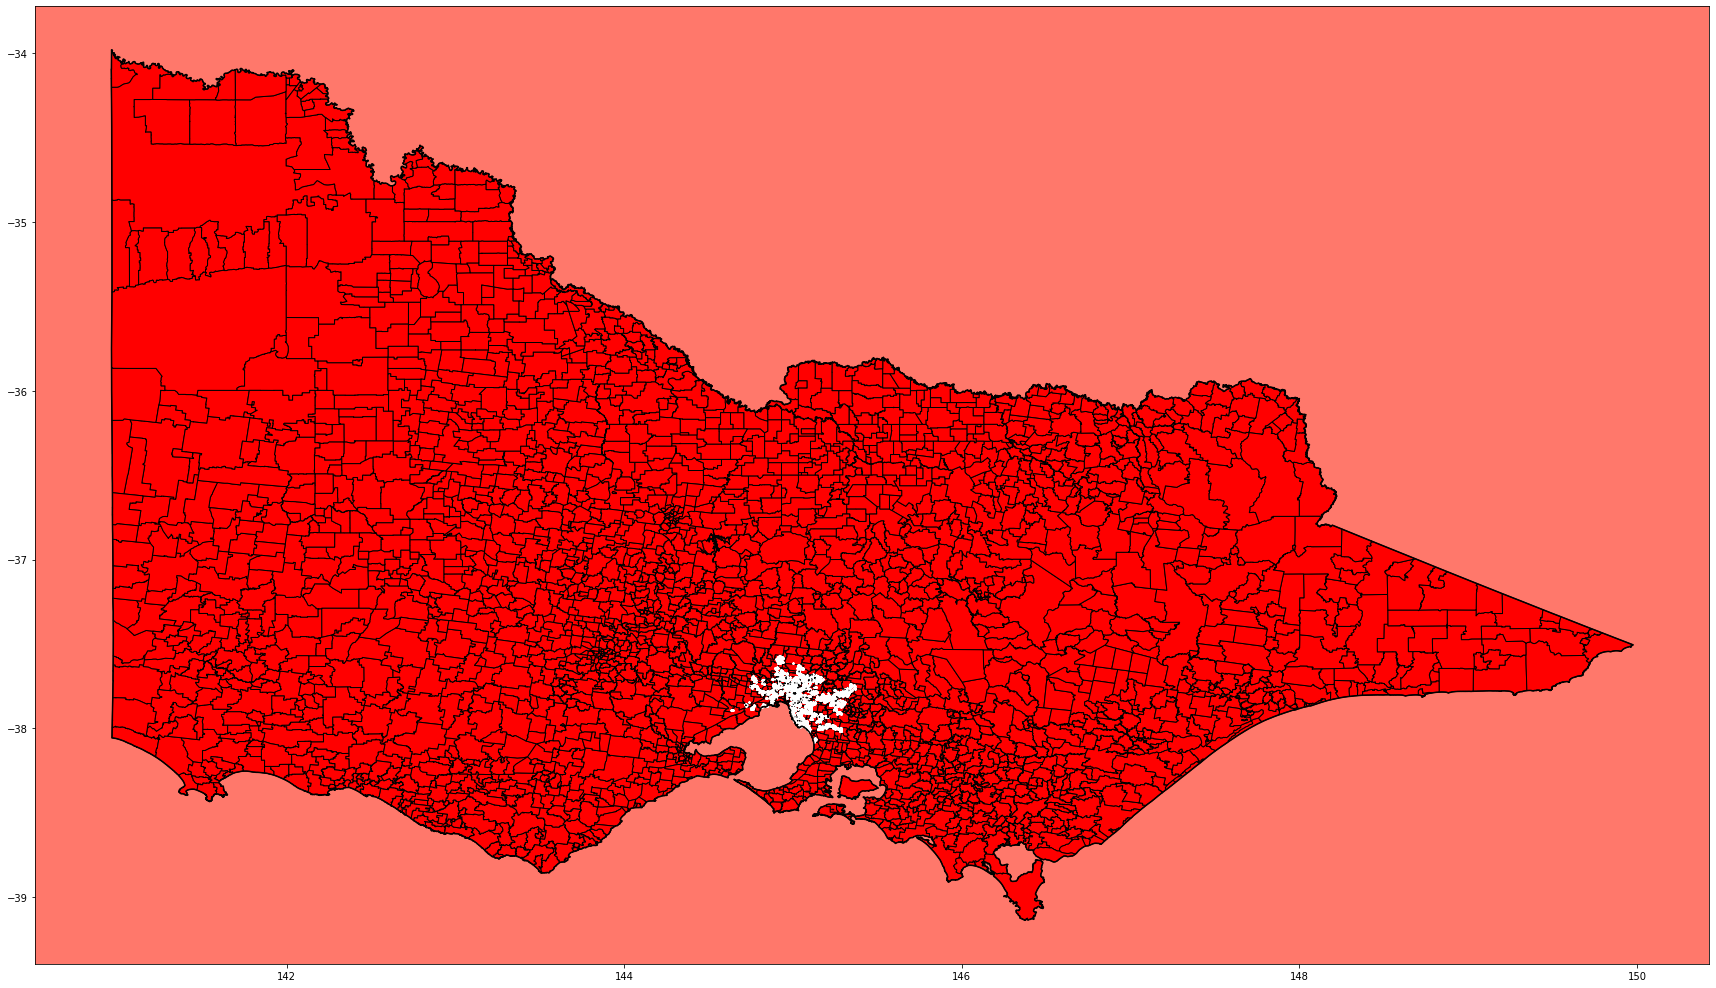

In [135]:
geometry = [Point(xy) for xy in zip( pdfxml_df['lng'], pdfxml_df['lat'] )]
geo_df = gpd.GeoDataFrame(geometry = geometry)

plt.rcParams["figure.figsize"] = (30, 30)

ax = shp_file.plot(color='red', edgecolor = 'black')
ax.set_facecolor((1.0, 0.47, 0.42))
ax = gpd.GeoSeries(shp_file['geometry'].unary_union).boundary.plot(ax=ax, color="black")
ax = geo_df.plot(ax = ax, markersize = 5, color = 'white', marker = '*', label = 'Victoria')

plt.show()

##**FINDING THE NEAREST RAILWAY STATION**
The next issue to solve is to find the nearest railway station to the location. For this, the stationloc file is read and based on the haversine formula, the distance to the nearest station is obtained using the lat and lon variables. 


In [136]:
stations = pd.read_csv(stationloc, sep = ",")
stations = stations.astype({"stop_id":"int", "stop_name":"str", "stop_short_name":"str", "stop_lat":"float", "stop_lon":"float"})

stations.head()

,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
0,15351,Sunbury Railway Station,Sunbury,-37.579091,144.727319
1,15353,Diggers Rest Railway Station,Diggers Rest,-37.627017,144.719922
2,19827,Stony Point Railway Station,Crib Point,-38.374235,145.221837
3,19828,Crib Point Railway Station,Crib Point,-38.366123,145.204043
4,19829,Morradoo Railway Station,Crib Point,-38.354033,145.189602


In [137]:
pdfxml_df["closest_train_station_id"] = 0
pdfxml_df["distance_to_closest_train_station"] = 0

r = 6378

for i in pdfxml_df.index:
    
    lowest_distance = r
    
    for j in stations.index:
        lon1, lat1, lon2, lat2 = map(radians, [pdfxml_df["lng"][i], pdfxml_df["lat"][i], stations["stop_lon"][j], stations["stop_lat"][j]])

        #haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a))
        distance = c * r

        if(lowest_distance > distance):
            lowest_distance = distance
            pdfxml_df.iloc[i, pdfxml_df.columns.get_loc('closest_train_station_id')] = stations["stop_id"][j]
            pdfxml_df.iloc[i, pdfxml_df.columns.get_loc('distance_to_closest_train_station')] = lowest_distance

pdfxml_df.head()

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station
0,86872,-37.916198,145.002380,52 Halifax Street,BRIGHTON,19951,0.546997
1,9851,-37.891016,144.636623,6 Edinburgh Court,WERRIBEE,19921,2.344456
2,76005,-37.901199,145.094908,26 Regent Street,OAKLEIGH,19917,0.587001
3,62603,-37.821757,145.246045,17 Bedford Court,HEATHMONT,19871,0.742471
4,83133,-37.875895,145.248093,28 Appleberry Close,KNOXFIELD,19869,3.623044


On using the haversine formula, the nearest station ID is obtained. The haversine formula helps us to retrive the distance based on the latitide and longitude of a loaction. By this, we have the details of the nearest train station to the suburb. Based on the property id and the closest distance, the dataframe is appended again to the pdfxml_df file.  
In this daatframe we have the details of the property ID, latitude, longitude, address, suburb name, nearest railway station, distance to the station and the flag value for the case if a direct train is available to the Melbourne Central railway station. 

In [138]:
melbourne_df = stations[stations["stop_name"].str.contains("Melbourne Central")]
melbourne_stop = melbourne_df["stop_id"].values[0]
print(melbourne_stop)

pdfxml_df["travel_min_to_MC"] = -1
pdfxml_df.loc[pdfxml_df["closest_train_station_id"] == melbourne_stop, "travel_min_to_MC"] = 0
pdfxml_df.head()

19842


,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC
0,86872,-37.916198,145.002380,52 Halifax Street,BRIGHTON,19951,0.546997,-1
1,9851,-37.891016,144.636623,6 Edinburgh Court,WERRIBEE,19921,2.344456,-1
2,76005,-37.901199,145.094908,26 Regent Street,OAKLEIGH,19917,0.587001,-1
3,62603,-37.821757,145.246045,17 Bedford Court,HEATHMONT,19871,0.742471,-1
4,83133,-37.875895,145.248093,28 Appleberry Close,KNOXFIELD,19869,3.623044,-1


Based on the flags value for the avilability of direct trains to the Melbourne Central, if there is no direct train available, then the value "not available" replaces the flag value. The chunk below shows the trains that do not have direct trains during the weekdays. 

In [139]:
day_df = pd.read_csv(calendarloc)
day_df = day_df.astype({"monday":"int", "tuesday":"int", "wednesday":"int", "thursday":"int", "friday":"int"})
day_df["combined"] = day_df["monday"]+day_df["tuesday"]+day_df["wednesday"]+day_df["thursday"]+day_df["friday"]

weekdays_zero = list( day_df[day_df["combined"] == 0]["service_id"] )
print("Service ID's where weekdays are zero: " + str(weekdays_zero))

Service ID's where weekdays are zero: ['T2', 'UJ', 'T2_1', 'UJ_1', 'T2_2', 'UJ_2']


Now we have the values for if there are direct trains to the Melbourne Central station. The next step is to find the detailf of the trains that are directly connected to the Melbourne central station. The code chunk below shows the trains which have direct connection to the MC station.

In [140]:
stop_times = pd.read_csv(stoptimeloc)
stop_times["service_id"] = stop_times["trip_id"].str.split(".").str[1]
print("All the Service ID's are: " + str(stop_times["service_id"].unique()))

def correct_format(t):
    val = t.split(":")
    if(int(val[0]) >= 24):
        new_value = ":".join( [str(int(val[0]) -24), val[1], val[2]] )
    else:
        new_value = ":".join(val[:])
    return new_value

stop_times["arrival_time"] = stop_times["arrival_time"].apply(correct_format)
stop_times["departure_time"] = stop_times["departure_time"].apply(correct_format)
stop_times["arrival_time"] = pd.to_datetime(stop_times["arrival_time"], format='%H:%M:%S')
stop_times["departure_time"] = pd.to_datetime(stop_times["departure_time"], format='%H:%M:%S')

stop_times = stop_times[~stop_times["service_id"].isin(weekdays_zero)]
stop_times = stop_times.reset_index(drop=True)
print("Service ID's present after removing where they are zero: " + str(stop_times["service_id"].unique()))


unique_trips = stop_times["trip_id"].unique()
print("Number of unique trips: " + str(len(unique_trips)))

All the Service ID's are: ['T2' 'UJ' 'T6' 'T5' 'T0']
Service ID's present after removing where they are zero: ['T6' 'T5' 'T0']
Number of unique trips: 13017


In [141]:
unique_stops = {}
for trips in unique_trips:

    df = stop_times[stop_times["trip_id"] == trips]
    if(melbourne_stop in df["stop_id"].unique()):
        
        df = df[((df["departure_time"].dt.hour >= 7) & (df["departure_time"].dt.hour <= 8)) | (df["stop_id"] == melbourne_stop)]
        if(len(df) > 1):
            df = df.reset_index(drop=True)
            index_value = df[df["stop_id"] == melbourne_stop].index.tolist()[0]
            df = df.drop(df.index[index_value+1:])
            df["duration"] = None

            for i in df.index:
                df.iloc[i, df.columns.get_loc("duration")] = int(( df["arrival_time"][index_value] - df["departure_time"][i] ).total_seconds() / 60)
                if(df["stop_id"][i] in unique_stops.keys()):
                    unique_stops[df["stop_id"][i]].append(df["duration"][i])
                else:
                    unique_stops[df["stop_id"][i]] = [df["duration"][i]]

del unique_stops[19842]

stop_minutes = {}
for stop_id, list_of_times in unique_stops.items():
    sum = 0
    for time in list_of_times:
        sum = sum + time
    stop_minutes[stop_id] = round(sum/len(list_of_times))

for stop_id, minutes in stop_minutes.items():
    pdfxml_df.loc[pdfxml_df["closest_train_station_id"] == stop_id, "travel_min_to_MC"] = minutes

pdfxml_df.head()

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC
0,86872,-37.916198,145.002380,52 Halifax Street,BRIGHTON,19951,0.546997,-1
1,9851,-37.891016,144.636623,6 Edinburgh Court,WERRIBEE,19921,2.344456,-1
2,76005,-37.901199,145.094908,26 Regent Street,OAKLEIGH,19917,0.587001,26
3,62603,-37.821757,145.246045,17 Bedford Court,HEATHMONT,19871,0.742471,37
4,83133,-37.875895,145.248093,28 Appleberry Close,KNOXFIELD,19869,3.623044,44


If a direct path to the MCS is not available, then a "not available" value is assigned to the "travel_min_to_MC" column. The other values show the minimum time in terms of minutes of travel to the MCS.

In [142]:
notrain_stationlist = list(pdfxml_df[pdfxml_df["travel_min_to_MC"] == -1]["closest_train_station_id"].unique())
notrain_triplist = list(stop_times[stop_times["stop_id"].isin(notrain_stationlist)]["trip_id"].unique())
train_to_melb_stationlist = stop_minutes.keys()

for trip in notrain_triplist:
    df = stop_times[stop_times["trip_id"] == trip]
    df = df[((df["departure_time"].dt.hour >= 7) & (df["departure_time"].dt.hour <= 8))]
    if(len(df) > 0):
        for station in notrain_stationlist:
            if(station in list(df["stop_id"])) and ( any((True for x in list(df["stop_id"]) if x in train_to_melb_stationlist)) ):
                pdfxml_df.loc[pdfxml_df["closest_train_station_id"] == station, "travel_min_to_MC"] = "not available"

pdfxml_df.head()

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC
0,86872,-37.916198,145.002380,52 Halifax Street,BRIGHTON,19951,0.546997,not available
1,9851,-37.891016,144.636623,6 Edinburgh Court,WERRIBEE,19921,2.344456,not available
2,76005,-37.901199,145.094908,26 Regent Street,OAKLEIGH,19917,0.587001,26
3,62603,-37.821757,145.246045,17 Bedford Court,HEATHMONT,19871,0.742471,37
4,83133,-37.875895,145.248093,28 Appleberry Close,KNOXFIELD,19869,3.623044,44


In [143]:
pdfxml_df["direct_journey_flag"] = -1

pdfxml_df.loc[((pdfxml_df["travel_min_to_MC"] == "not available" ) | ( pdfxml_df["travel_min_to_MC"] == 0 )), "direct_journey_flag"] = 0

for i in pdfxml_df.index:
    if(pdfxml_df["travel_min_to_MC"][i] not in ["not available", 0]):
        pdfxml_df.iloc[i, pdfxml_df.columns.get_loc('direct_journey_flag')] = 1

pdfxml_df.loc[pdfxml_df["travel_min_to_MC"] == -1, "direct_journey_flag"] = -1

pdfxml_df.head()

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag
0,86872,-37.916198,145.002380,52 Halifax Street,BRIGHTON,19951,0.546997,not available,0
1,9851,-37.891016,144.636623,6 Edinburgh Court,WERRIBEE,19921,2.344456,not available,0
2,76005,-37.901199,145.094908,26 Regent Street,OAKLEIGH,19917,0.587001,26,1
3,62603,-37.821757,145.246045,17 Bedford Court,HEATHMONT,19871,0.742471,37,1
4,83133,-37.875895,145.248093,28 Appleberry Close,KNOXFIELD,19869,3.623044,44,1


MERGING SUBURB DATA WITH THE LOCATION DATA

We have the suburb data and the location data. The next step is to merge them so as to perform further analysis like normalisation and transformation. The final data is the one that is the suburb data and the location data merged together. In this dataframe, we have details like the property id, latitude, longitude, address, suburb, closest station, distance to the station, travel duration , direct train availability flags. This data is saved as a csv file.

In [144]:
linear_data_df = pd.merge(pdfxml_df, suburb_df, how='left', on='suburb')
linear_data = linear_data_df[["Median_house_price","House_quarterly_growth","House_twelve_month_growth","House_average_annual_growth"]]

linear_data_df["Median_house_price"] = linear_data_df["Median_house_price"].replace("N/A", "not extracted")
linear_data_df["House_quarterly_growth"] = linear_data_df["House_quarterly_growth"].replace("N/A", "not extracted")
linear_data_df["House_twelve_month_growth"] = linear_data_df["House_twelve_month_growth"].replace("N/A", "not extracted")
linear_data_df["House_average_annual_growth"] = linear_data_df["House_average_annual_growth"].replace("N/A", "not extracted")

print(pdfxml_df.shape)
print(suburb_df.shape)
print(linear_data_df.shape)

linear_data_df.to_csv(r"/content/drive/My Drive/DW3/32263546_A3_solution.csv", index = False)


(2115, 9)
(2099, 6)
(2115, 14)


In [145]:
linear_data

,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth
0,"$3,416,000",9.81%,8.42%,8.42%
1,"$560,000",14.02%,16.88%,4.88%
2,"$1,360,000",12.10%,35.94%,2.11%
3,"$1,024,000",11.61%,28.78%,3.55%
4,"$968,150",11.36%,8.09%,0.86%
...,...,...,...,...
2110,"$990,000",12.20%,24.71%,7.99%
2111,"$576,500",10.20%,22.73%,9.36%
2112,"$820,000",11.29%,21.05%,5.73%
2113,"$608,000",11.00%,25.00%,10.45%


##NORMALISATION AND TRANSFORMATION OF THE DATA
For linear models to perform with better accuracy, normalisation and data transformation is usually done. Here assuming that we have to build a linear model to predict the House_quarterly_growth using Median_house_price House_twelve_month_growth, House_average_annual_growth, the required transformtation and normalisation is performed in the below chunks. Z-transformation (standardised) and the Min-Max normalisation, is performed. Since the log transformation is considered to be working better than the other methods, it is used. 
I have used both the standardised and the Minmax normalisation. To see the impact that these methods have on data, Individual plots for the the original, standardised and the min-max normalised data is plotted. 
The four columns namely Median house price, house quarterly growth, house twelve month growth, and the house average annual growth are taken as a separate dataframe and the values are converted to float so as to perform normalisation and transformation. 

In [146]:
for col in linear_data.columns:
    linear_data[col] = linear_data[col].map(lambda x: str(x).replace('$',''))
    linear_data[col] = linear_data[col].map(lambda x: str(x).replace(',',''))
    linear_data[col] = linear_data[col].map(lambda x: str(x).replace('%',''))
    linear_data[col] = linear_data[col].replace('N/A', None)
    linear_data[col] = linear_data[col].astype("float")
print(linear_data)


      Median_house_price  House_quarterly_growth  House_twelve_month_growth  \
0              3416000.0                    9.81                       8.42   
1               560000.0                   14.02                      16.88   
2              1360000.0                   12.10                      35.94   
3              1024000.0                   11.61                      28.78   
4               968150.0                   11.36                       8.09   
...                  ...                     ...                        ...   
2110            990000.0                   12.20                      24.71   
2111            576500.0                   10.20                      22.73   
2112            820000.0                   11.29                      21.05   
2113            608000.0                   11.00                      25.00   
2114            850000.0                   14.48                      22.51   

      House_average_annual_growth  
0              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

##Original data

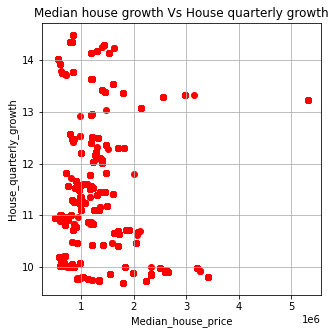

In [147]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.title('Median house growth Vs House quarterly growth')
plt.scatter(linear_data["Median_house_price"],linear_data["House_quarterly_growth"], color='red')
plt.xlabel("Median_house_price")
plt.ylabel("House_quarterly_growth")
plt.grid()

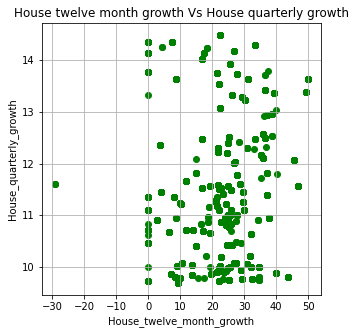

In [148]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.title('House twelve month growth Vs House quarterly growth')
plt.scatter(linear_data["House_twelve_month_growth"],linear_data["House_quarterly_growth"], color='green')
plt.xlabel("House_twelve_month_growth")
plt.ylabel("House_quarterly_growth")
plt.grid()

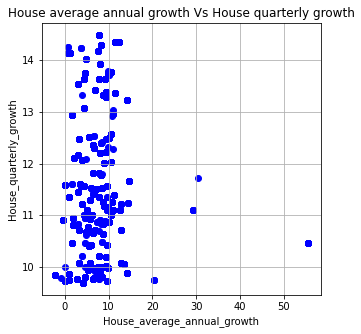

In [149]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.title('House average annual growth Vs House quarterly growth')
plt.scatter(linear_data["House_average_annual_growth"],linear_data["House_quarterly_growth"], color = 'blue')
plt.xlabel("House_average_annual_growth")
plt.ylabel("House_quarterly_growth")
plt.grid()

##Min-Max normalisation

In [150]:
from sklearn import preprocessing
min_max_scale = preprocessing.MinMaxScaler().fit(linear_data[["Median_house_price","House_quarterly_growth","House_twelve_month_growth","House_average_annual_growth"]])
min_max = min_max_scale.transform(linear_data[["Median_house_price","House_quarterly_growth","House_twelve_month_growth","House_average_annual_growth"]])
min_max_df = pd.DataFrame(min_max, columns = ["Median_house_price","House_quarterly_growth","House_twelve_month_growth","House_average_annual_growth"] )
min_max_df

,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth
0,0.605171,0.023013,0.475842,0.186163
1,0.014478,0.903766,0.582566,0.125086
2,0.179938,0.502092,0.823010,0.077295
3,0.110445,0.399582,0.732686,0.102139
4,0.098893,0.347280,0.471679,0.055728
...,...,...,...,...
2110,0.103413,0.523013,0.681342,0.178744
2111,0.017890,0.104603,0.656364,0.202381
2112,0.068252,0.332636,0.635171,0.139752
2113,0.024405,0.271967,0.685001,0.221187


In [151]:
scaler = preprocessing.StandardScaler().fit(linear_data[["Median_house_price","House_quarterly_growth","House_twelve_month_growth","House_average_annual_growth"]])
standard = scaler.transform(linear_data[["Median_house_price","House_quarterly_growth","House_twelve_month_growth","House_average_annual_growth"]])
standard_df = pd.DataFrame(standard, columns = ["Median_house_price","House_quarterly_growth","House_twelve_month_growth","House_average_annual_growth"] )
standard_df


,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth
0,3.244099,-1.247153,-1.188997,0.005488
1,-1.094377,1.828400,-0.460734,-0.433451
2,0.120882,0.425772,1.180009,-0.776914
3,-0.389527,0.067810,0.563655,-0.598363
4,-0.474367,-0.114824,-1.217404,-0.931907
...,...,...,...,...
2110,-0.441175,0.498826,0.213296,-0.047829
2111,-1.069312,-0.962244,0.042852,0.122042
2112,-0.699418,-0.165961,-0.101768,-0.328056
2113,-1.021462,-0.377816,0.238260,0.257196


**ORIGINAL DATA**

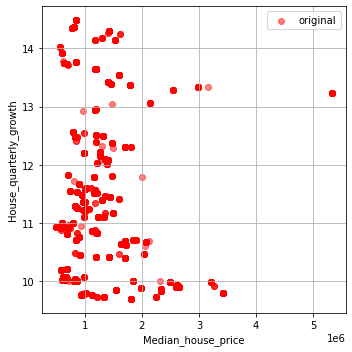

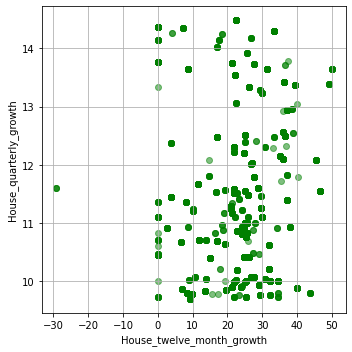

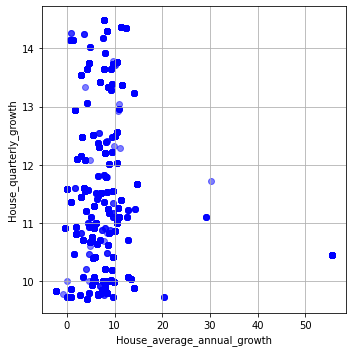

In [152]:

plt.figure(figsize=(5,5))
plt.scatter(linear_data["Median_house_price"], linear_data['House_quarterly_growth'],
          color='red', label='original', alpha=0.5)


plt.xlabel('Median_house_price')
plt.ylabel('House_quarterly_growth')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()
plt.show()


plt.scatter(linear_data["House_twelve_month_growth"], linear_data['House_quarterly_growth'],
          color='green', label='house_twelve_month_growth', alpha=0.5)
plt.xlabel('House_twelve_month_growth')
plt.ylabel('House_quarterly_growth')
#plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()
plt.show()


plt.scatter(linear_data["House_average_annual_growth"], linear_data['House_quarterly_growth'],
          color='blue', label='House average annual growth', alpha=0.5)
plt.xlabel('House_average_annual_growth')
plt.ylabel('House_quarterly_growth')
#plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()


plt.show()


**Z-TRANSFORMATION**

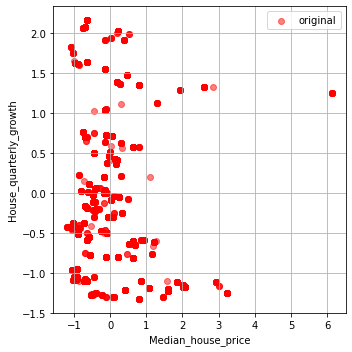

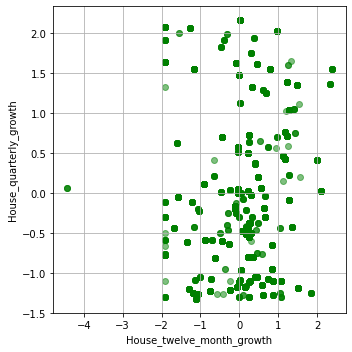

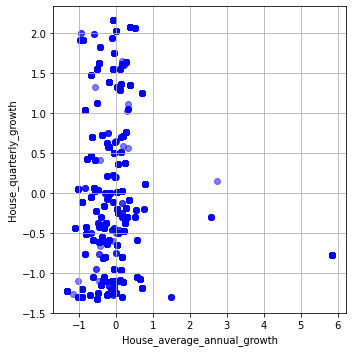

In [153]:
plt.figure(figsize=(5,5))
plt.scatter(standard_df["Median_house_price"], standard_df['House_quarterly_growth'],
          color='red', label='original', alpha=0.5)
plt.xlabel('Median_house_price')
plt.ylabel('House_quarterly_growth')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()
plt.show()


plt.scatter(standard_df["House_twelve_month_growth"], standard_df['House_quarterly_growth'],
          color='green', label='house_twelve_month_growth', alpha=0.5)
plt.xlabel('House_twelve_month_growth')
plt.ylabel('House_quarterly_growth')
#plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()
plt.show()


plt.scatter(standard_df["House_average_annual_growth"], standard_df['House_quarterly_growth'],
          color='blue', label='House average annual growth', alpha=0.5)
plt.xlabel('House_average_annual_growth')
plt.ylabel('House_quarterly_growth')
#plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()


             

**MINMAX NORMALISATION**

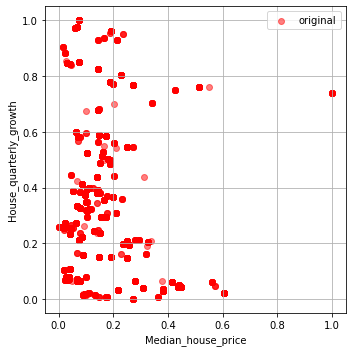

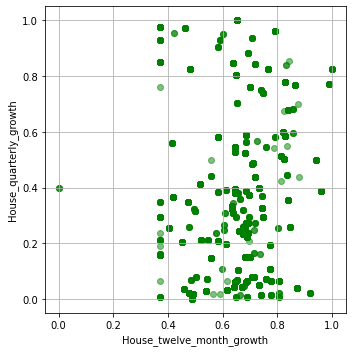

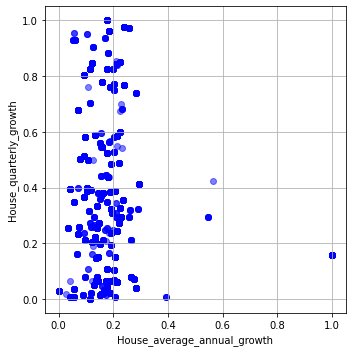

In [154]:
plt.figure(figsize=(5,5))
plt.scatter(min_max_df["Median_house_price"], min_max_df['House_quarterly_growth'],
          color='red', label='original', alpha=0.5)
plt.xlabel('Median_house_price')
plt.ylabel('House_quarterly_growth')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()
plt.show()


plt.scatter(min_max_df["House_twelve_month_growth"], min_max_df['House_quarterly_growth'],
          color='green', label='house_twelve_month_growth', alpha=0.5)
plt.xlabel('House_twelve_month_growth')
plt.ylabel('House_quarterly_growth')
#plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()
plt.show()


plt.scatter(min_max_df["House_average_annual_growth"], min_max_df['House_quarterly_growth'],
          color='blue', label='House average annual growth', alpha=0.5)
plt.xlabel('House_average_annual_growth')
plt.ylabel('House_quarterly_growth')
#plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

Thus, it is evident that on performing the normlisation the visualisation in the data changes in comparison to the orginal data. On performing transformation and normalisation, there is an improvement in the data which proves the fact that it could improve the accuracy given that a linear model is built to predict the prices using the other three variables

Thus, the data is integrated and transformed into a useful data that can be used for futher analysis. 

References:
Tutorial materials.